Частично основано на
https://www.kaggle.com/kaggleuser983/notebook3c64cdafe5

Работу выполнил: Доронькин Максим Вячеславович, студент 3 курса факультета физики НИУ ВШЭ (Москва).

## Установка и импорт необходимых библиотек

In [1]:
!pip install strsimpy pytorch-lightning

!cp ../input/payment-detection/utils.py ./utils.py

#!pip install --upgrade torchvision

#!pip install --upgrade torchtext

import torch
import pandas as pd


from PIL import Image
import cv2
import gc
import time

from torch.autograd import Variable
from torch.optim import Adam, Adagrad, SGD
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR, StepLR, ReduceLROnPlateau

import random

from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import tqdm
from torch.nn import functional as fnn
from torch.utils import data
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn import Module, Sequential, Conv2d, AvgPool2d, GRU, Linear
from torch.nn.functional import ctc_loss, log_softmax
from torchvision import models


import torchvision
import pickle
import json

from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import *

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import pytorch_lightning as pl

from itertools import chain

import torch.distributed as dist

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.patches as patches


import os
import tqdm
import json
import numpy as np

from string import digits, ascii_uppercase
from collections import defaultdict

import math 
import utils

from strsimpy.levenshtein import Levenshtein

In [2]:
torch.cuda.is_available()

False

## Фиксация random seeds и определение гиперпараметров

In [3]:
SEED = 1489


random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Пара слов о подборе гиперпараметров, которые заходили и не заходили у меня. Довольно скоро я понял, что важную роль в победе играет Threshold, как в этом и убедился после окончания соревнования, я применял различные и смотрел на уверенности в ответах сети. Вводил два порога, один очень высокий, мне было интересно посмотреть как хорошо совпадают с реальными предсказания сети с высокой уверенностью. Размер батча сперва ставил равным 16 и 12, но затем экспериментально понял, что чуть меньший заходит лучше, остановился на 8. Далее я много времени посвятил оверсемплингу, который детально представлю чуть ниже. Подбор гиперпараметров, давших мне моё лучшее решение, ниже:

In [5]:
#определение констант

#пути к файлам
TEST_PATH = "../input/payment-detection/test/test" 
TRAIN_PATH = "../input/payment-detection/train/train"
SUBMISSION_PATH = "../input/payment-detection/submission.csv"
TRAIN_INFO = "../input/payment-detection/train.csv"
#константы оверсемплинга
OS_MANY = 1
OS_UY = 3
OS_EX = 2
OS_ST = 2
OS_PC = 0
# уверенность в детектируемом объекте
THRESHOLD = 0.7
HOT_THRESHOLD = 0.975 #0.7#0.7#0.6
# уверенность в детектируемом объекте в случае полного отсутствия предсказания
EMPTY_STRING_THRESHOLD = 0.5
# размер для ресайзинга изображений
IMAGE_WIDTH = 412#800#800#412  
IMAGE_HEIGHT = 412#800#800#412  

# Размер валидационной выборки
VAL_SIZE = 0.2

# Количество итераций
N_ITER = 12

# Размер батча
BATCH_SIZE = 8
BATCH_SIZE_VAL = 8


LR = 1e-4
cpu_device = torch.device("cpu")

### Загрузка данных

In [6]:
train_df  = pd.read_csv(TRAIN_INFO)

In [7]:
test_df = pd.read_csv(SUBMISSION_PATH)

In [8]:
valid_images = np.random.choice(train_df.image.unique(), size=int(VAL_SIZE * train_df.image.nunique()), replace=False)

valid_set = train_df[train_df.image.isin(valid_images)]

train_set = train_df[~train_df.image.isin(valid_images)]

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
  
def get_dict(df):
    train_dict = defaultdict(list)
    for i, row in df.iterrows():
        train_dict[row.image].append([int(row.x1 *(IMAGE_WIDTH/ row.width)), #xmin
                                     int(row.y1 * (IMAGE_HEIGHT/ row.height)),#ymin
                                     int((row.x1 + row.w)*(IMAGE_WIDTH/ row.width)), #xmax
                                     int((row.y1 + row.h)*(IMAGE_HEIGHT/ row.height)), #ymax
                                     row.label]) #label
    for k in train_dict.keys():
        train_dict[k].sort(key = lambda x: (x[0], x[1]))
    return train_dict

In [10]:
train_dict = get_dict(train_set)
val_dict = get_dict(valid_set)

## OVERSAMPLING. Дублирование данных с редкими таргетными значениями

In [11]:
#Посмотрим на изначальное распределение в данных
dict_ph = []
Ma = 0
Ex = 0
Pc = 0
Uy = 0
Vi = 0
St = 0
for photo in train_dict.keys():
    for card in train_dict[photo]:
        if card[4] == 'MA':
            Ma += 1
        if card[4] == 'EX':
            Ex += 1
        if card[4] == 'PC':
            Pc += 1
        if card[4] == 'UY':
            Uy += 1
        if card[4] == 'VI':
            Vi += 1
        if card[4] == 'ST':
            St += 1
print('MA -',Ma,',EX -', Ex,',PC -', Pc,',UY -', Uy,',VI -', Vi, ',ST -',St)

MA - 1018 ,EX - 43 ,PC - 129 ,UY - 23 ,VI - 1363 ,ST - 61


In [12]:
#проведём оверсемплинг по принципу примеров с большим числом карт
train_dat = [item for item in train_dict.items()]
for i in range(len(train_dat)):
    train_dat[i] = list(train_dat[i])

for oversampling_iteration in range(OS_MANY):
    num = 0
    for i in range(len(train_dat)):
        vow = train_dat[i]
        if len(vow[1]) >= 7:
            vow[0] = vow[0]+'_'+str(num)
            train_dat.append(vow)
            num+=1
    new_strings = []
    for i in range(len(train_dat)):
        if '_' in train_dat[i][0]:
            new_strings.append(train_dat[i])
    for elem in new_strings:
        train_dict.update({elem[0]:elem[1]})

In [13]:
#проведём оверсемплинг по редким картам среди всего датасета.
for oversampling_iteration in range(OS_UY):
    num = 0
    for i in range(len(train_dat)):
        vow = train_dat[i]
        for card in vow[1]:
            if card[4] == 'UY':
                vow[0] = vow[0]+'_'+str(num)
                train_dat.append(vow)
                num+=1
                break
    new_strings = []
    for i in range(len(train_dat)):
        if '_' in train_dat[i][0]:
          #  print(train_dat[i][0])
            new_strings.append(train_dat[i])
    for elem in new_strings:
        train_dict.update({elem[0]:elem[1]})
        
for oversampling_iteration in range(OS_EX):
    for i in range(len(train_dat)):
        vow = train_dat[i]
        for card in vow[1]:
            if card[4] == 'EX':
                vow[0] = vow[0]+'_'+str(num)
                train_dat.append(vow)
                num += 1
                break
    new_strings = []
    for i in range(len(train_dat)):
        if '_' in train_dat[i][0]:
          #  print(train_dat[i][0])
            new_strings.append(train_dat[i])
    for elem in new_strings:
        train_dict.update({elem[0]:elem[1]})
for oversampling_iteration in range(OS_ST):
    for i in range(len(train_dat)):
        vow = train_dat[i]
        for card in vow[1]:
            if card[4] == 'ST':
                vow[0] = vow[0]+'_'+str(num)
                train_dat.append(vow)
                num += 1
                break
    new_strings = []
    for i in range(len(train_dat)):
        if '_' in train_dat[i][0]:
          #  print(train_dat[i][0])
            new_strings.append(train_dat[i])
    for elem in new_strings:
        train_dict.update({elem[0]:elem[1]})
for oversampling_iteration in range(OS_PC):
    num = 0
    for i in range(len(train_dat)):
        vow = train_dat[i]
        for card in vow[1]:
            if card[4] == 'PC':
                vow[0] = vow[0]+'_'+str(num)
                train_dat.append(vow)
                num+=1
                break
    new_strings = []
    for i in range(len(train_dat)):
        if '_' in train_dat[i][0]:
          #  print(train_dat[i][0])
            new_strings.append(train_dat[i])
    for elem in new_strings:
        train_dict.update({elem[0]:elem[1]})

In [14]:
#посмотрим на распределение в данных после операции оверсемплинга
dict_ph = []
Ma = 0
Ex = 0
Pc = 0
Uy = 0
Vi = 0
St = 0
for photo in train_dict.keys():
    for card in train_dict[photo]:
        if card[4] == 'MA':
            Ma += 1
        if card[4] == 'EX':
            Ex += 1
        if card[4] == 'PC':
            Pc += 1
        if card[4] == 'UY':
            Uy += 1
        if card[4] == 'VI':
            Vi += 1
        if card[4] == 'ST':
            St += 1
print('MA -',Ma,',EX -', Ex,',PC -', Pc,',UY -', Uy,',VI -', Vi, ',ST -',St)

MA - 1327 ,EX - 140 ,PC - 198 ,UY - 97 ,VI - 1938 ,ST - 207


В конечном итоге оверсемплинг мне не очень сильно помог, но всё же несколько сотых у меня он помогал съесть на LB. Важнее было с ним не переборщить, ибо эффект от слишком большого оверсемплинга очень заметен и неприятен оказался, как я убеждался.

Ещё я обнаружил, что на тренировочных данных очень грязная разметка, а также достаточно много фото-дубликатов, у меня была идея убрать все дубликаты, оставляю код для избавления тренировочных данных от дубликатов ниже, но не использую его, так как, в конечном итоге, этот подход не принёс мне успехов, удаление дубликатов не повлияло на улучшения предсказаний моей сети. 
(эта операция проводится, конечно, до оверсемплинга, просто вынес в конец раздела, как несущественное в итоге.)

In [15]:
"""
hashes = []
train_df_ = train_df.drop_duplicates(subset = ['image'])
for i in tqdm.tqdm(range(len(train_df_))):
  image_name = train_df_.iloc[i].image
  img = Image.open(os.path.join(TRAIN_PATH, image_name))
  hashes.append(imagehash.phash(img).hash.reshape(64))

hashes = torch.Tensor(np.array(hashes).astype(int)).cuda()
sims = np.array([(hashes[i] == hashes).sum(dim=1).cpu().numpy()/64 for i in range(hashes.shape[0])])
train_df_['image_'] = train_df_['image'].apply(lambda x: os.path.join(TRAIN_PATH, x))

threshold = 0.92
paths = train_df_.image_.values
duplicates = np.where((sims > threshold))


train_df_['duplicates'] = ''
for i in tqdm.tqdm(range(len(sims))):
  for j in range(len(sims)):
    if i == j:
        continue
    if sims[i][j] > threshold:
      train_df_['duplicates'].iloc[i] = f'duplicate_{i}'
      train_df_['duplicates'].iloc[j] = f'duplicate_{i}'
a = train_df_.drop_duplicates(subset = ['duplicates']).query("duplicates != ''")
b = train_df_.query("duplicates == ''")
data_without = pd.concat([a, b])
train_df = train_df[train_df.image.isin(data_without.image)]
"""

'\nhashes = []\ntrain_df_ = train_df.drop_duplicates(subset = [\'image\'])\nfor i in tqdm.tqdm(range(len(train_df_))):\n  image_name = train_df_.iloc[i].image\n  img = Image.open(os.path.join(TRAIN_PATH, image_name))\n  hashes.append(imagehash.phash(img).hash.reshape(64))\n\nhashes = torch.Tensor(np.array(hashes).astype(int)).cuda()\nsims = np.array([(hashes[i] == hashes).sum(dim=1).cpu().numpy()/64 for i in range(hashes.shape[0])])\ntrain_df_[\'image_\'] = train_df_[\'image\'].apply(lambda x: os.path.join(TRAIN_PATH, x))\n\nthreshold = 0.92\npaths = train_df_.image_.values\nduplicates = np.where((sims > threshold))\n\n\ntrain_df_[\'duplicates\'] = \'\'\nfor i in tqdm.tqdm(range(len(sims))):\n  for j in range(len(sims)):\n    if i == j:\n        continue\n    if sims[i][j] > threshold:\n      train_df_[\'duplicates\'].iloc[i] = f\'duplicate_{i}\'\n      train_df_[\'duplicates\'].iloc[j] = f\'duplicate_{i}\'\na = train_df_.drop_duplicates(subset = [\'duplicates\']).query("duplicates != 

## Создание датасета. Проведение аугментаций.

Из аугментаций я использовал почти всё, что сумел найти. Пробовал повороты с паддингом - не зашли, вариации с яркостью и контрастом заходили через раз, остановился на random brightness. Довольно хороши оказались флипы, но с ними важно было сохранить вид bounding box после переворотов, воспользовался albumentations.

In [16]:
import albumentations as A

#датасет для тренировки и валидации
class ShapeDataset(Dataset):

    def __init__(self, IMAGE_DIR, IMAGE_WIDTH, IMAGE_HEIGHT, data,
                 transform=transforms.Compose([ToTensor(), 
                                               
                                               
                                               #Pad(10, fill=0, padding_mode='constant'),
                                               #RandomApply([RandomRotation(90)], p=0.5),
                                               #random_rotation(20-30 degrees) apply 40%
                                               
                                               
                                               Normalize(
                                                   mean=[0.485, 0.456, 0.406],
                                                   std=[0.229, 0.224, 0.225]
                                               )])):
        
        self.IMAGE_DIR = IMAGE_DIR
        self.IMAGE_WIDTH = IMAGE_WIDTH
        self.IMAGE_HEIGHT = IMAGE_HEIGHT
        
        
        self.data = data
        self.transform = transform



    def num_classes(self):
        return 7

    def __len__(self, ):
        return len(self.data.keys())
    
    def __getitem__(self, idx):
              
        def get_boxes(obj):
            boxes = []
            for row in obj:
                boxes.append(row[:4])
            return torch.as_tensor(boxes, dtype=torch.float)

        def get_areas(obj):
            areas = []
            for row in obj:
                areas.append((row[2] - row[0]) * (row[3] - row[1]))
            return torch.as_tensor(areas, dtype=torch.int64)
        
        def get_class(obj):
            """
            Кодируем класс числом
            """
            cards = {
                'VI':1,
                'MA':2,
                'EX':3, 
                'PC':4, 
                'ST':5,
                'UY':6
                    }
            classes = []
            for row in obj:
                classes.append(cards[row[4]])
            return torch.as_tensor(classes, dtype=torch.int64)
        
        img_name = list(self.data.keys())[idx]
        
        #код в несколько строк ниже нужен для оверсемплинга
        
        check = img_name.find('_')   #  Находит на каком месте впервые встречается '_'
        
        if check != -1:   
            img_name_for_photo = img_name[0 : (check)]
        else:
            img_name_for_photo = img_name
            
        path = os.path.join(self.IMAGE_DIR, img_name_for_photo)

        
    
        img = cv2.imread(path)
        
        shapes  = img.shape
        
        img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT)) 
            
        obj = self.data[img_name]
        
        #аугментации от albumentations с учётом смещений bounding boxов
        transforms_a = A.Compose([
                                               A.HorizontalFlip(p=0.5),
                                               A.VerticalFlip(p=0.5),
                                               A.RandomBrightness(limit=0.1, always_apply=False, p=0.5)
                                               #A.RandomBrightnessContrast(p=0.2),
                                               ], bbox_params=A.BboxParams(format='pascal_voc'
                                                                        ))
       
        image = transforms_a(image=img, bboxes=self.data[img_name])
        
        obj = image['bboxes']
        
        img = image['image']
        
        target = {}
        target['boxes'] = get_boxes(obj)
        target['labels'] = get_class(obj)
        target['image_id'] = torch.as_tensor([idx], dtype=torch.int64)
        target['area'] = get_areas(obj)
        target['iscrowd'] = torch.zeros((len(obj),), dtype=torch.int64)
        
        if self.transform:
            image = self.transform(img)
        

        return image, target

#датасет для тестовых данных
class ShapeDatasetTest(Dataset):

    def __init__(self, IMAGE_DIR, IMAGE_WIDTH, IMAGE_HEIGHT, data,
                 transform=transforms.Compose([ToTensor(),
                                               Normalize(
                                                   mean=[0.485, 0.456, 0.406],
                                                   std=[0.229, 0.224, 0.225]
                                               ) ])):
        self.IMAGE_DIR = IMAGE_DIR
        self.IMAGE_WIDTH = IMAGE_WIDTH
        self.IMAGE_HEIGHT = IMAGE_HEIGHT
        
        
        self.data = data
        self.transform = transform


    def num_classes(self):
        return 7
    
    def __len__(self, ):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        
        img_name = self.data.iloc[idx]['image']
        
        path = os.path.join(self.IMAGE_DIR, img_name)
        
        
        img = cv2.imread(path)
        
        shapes  = img.shape

        img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT)) 
        
        
        if self.transform:
            image = self.transform(img)
            
        return image 


In [17]:
#инициация датасетов
train_data = ShapeDataset(TRAIN_PATH, IMAGE_WIDTH, IMAGE_HEIGHT, train_dict)
valid_data = ShapeDataset(TRAIN_PATH, IMAGE_WIDTH, IMAGE_HEIGHT, val_dict)
test_data  = ShapeDatasetTest(TEST_PATH, IMAGE_WIDTH, IMAGE_HEIGHT, test_df)

In [18]:
#инициация загрузчиков данных
dataloader_train = DataLoader(
    train_data, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=0, collate_fn=collate_fn)
dataloader_valid = DataLoader(
    valid_data, batch_size=BATCH_SIZE_VAL, 
    shuffle=False, num_workers=0, collate_fn=collate_fn)

# "Look at the data"

In [19]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

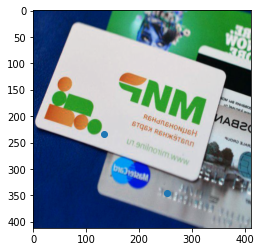

In [20]:
#демонстрация bounding box. Прямоугольник с данными правой нижней и левой верхне точкой и есть наш BB
fas = train_data[544]
x1, y1, x2, y2 = fas[1]['boxes'][0][0],fas[1]['boxes'][0][1],fas[1]['boxes'][0][2],fas[1]['boxes'][0][3]
#plt.rectangle((x1,y1), (x2,y2))
plt.scatter((x1,y1), (x2,y2))
#plt.scatter((x1,y2), (x2,y1))

inp = fas[0].numpy().transpose((1, 2, 0))


mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


inp = std * inp + mean
inp = np.clip(inp, 0, 1)
plt.imshow(inp)


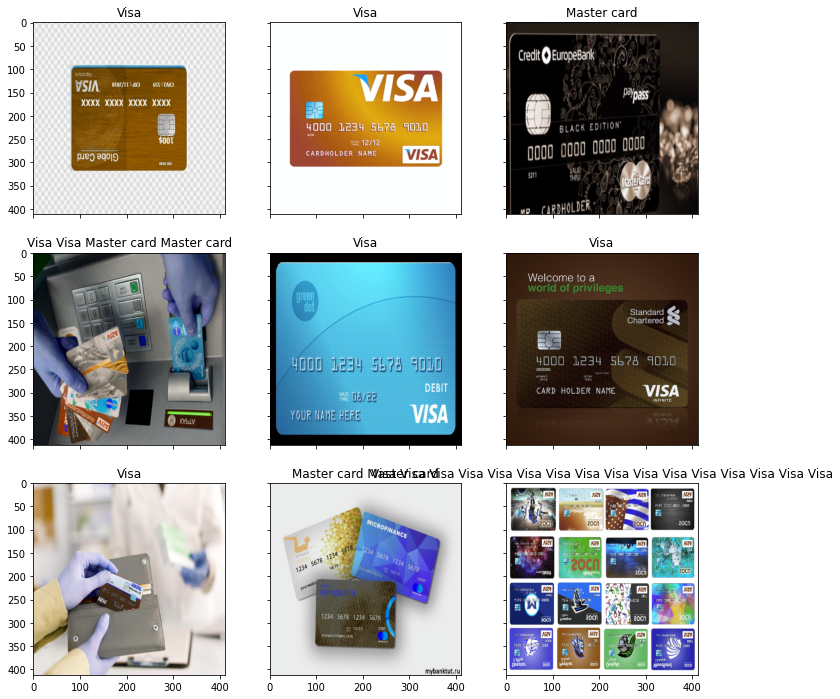

In [21]:
#демонстрация тренировочных данных
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    
    im_val = train_data[random_characters][0]
    
    card = train_data[random_characters][1]['labels'].numpy()
    
    cards = {
                'VISA':1,
                'MASTER CARD':2,
                'AMERICAN EXPRESS':3, 
                'MIR':4, 
                'MAESTRO':5,
                'UNION PAY':6
                    }
    
    def get_key(d, value):
        res = []
        for k, v in d.items():
            for value in card:
                if v == value:
                    res.append(k)
        return(res)

    items = get_key(cards, card[0])
    
    
    img_label = " ".join(map(lambda x: x.capitalize(),\
                items))
    
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

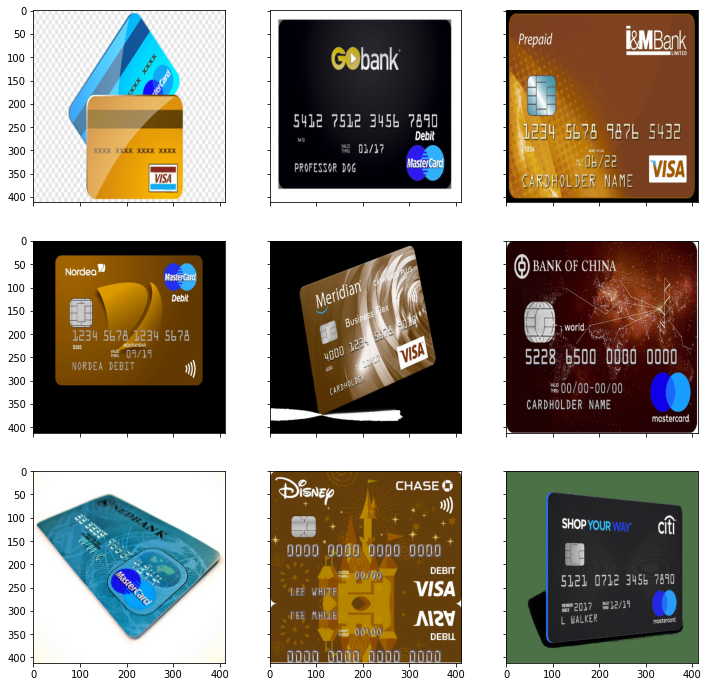

In [22]:
#демонстрация тестовых данных
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,100))
    
    im_val = test_data[random_characters]
    
    
    imshow(im_val.data.cpu(), plt_ax=fig_x)

## Загрузка моделей и установка параметров

Моделей подбирал очень много. Начинал с базового resnet50 Faster_RCNN, лучшего чем 0.6 не добивался на LB, далее решил придерживаться стратегии faster_RCNN и подбирал различные предобученные backbone, остановился на densenet, они обучаются лучше остальных на наших данных, вероятно потому что лучше других работают с небольшими датасетами. Пытался использовать Efficient Det, но быстро понял, что для её обучения точно нужно было бы больше данных. 
Также заметил, что trainable backbone layers лучше оказалось оставлять как можно больше, так что я совсем не стал здесь замораживать слои backbone, хотя часто так делают. В таблице ниже я описал случай с замороженными весами backbone. Заморозка не зашла для DenseNet

Представляю результаты своих тренировок в google таблицах:

https://docs.google.com/spreadsheets/d/14iNcTqGMZRhfFsfW-xtYruhaPDeaB24K0iB-u0x6G0k/edit?usp=sharing

In [ ]:
device = get_device()

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features


backbone = torchvision.models.densenet169(pretrained=True).features # 169 было
#print(len(list(backbone.children())))   #169 было
#for p in nn.Sequential(*list(backbone.children())[:7]).parameters():



# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1664 #1024 - 121 #2208 -161

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model_densenet = FasterRCNN(backbone,
                   num_classes=7,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

model_densenet = model_densenet.to(device)

## Метрика

In [ ]:
def lev_dist(preds, df_dict):
    
    
    def c_sort(sub_li):
        """
        Сортировка боксов по координатам. Слева направо сверху вниз.
        """
        sub_li.sort(key = lambda x: (x[0], x[1]))
        return sub_li
    
    def get_reversed_class(number):
        
        """
        Декодинг класса.
        """
        cards = {
                1:'VI',
                2:'MA',
                3:'EX', 
                4:'PC', 
                5:'ST',
                6:'UY'
                    }
        return cards[number]
    
    levenshtein = Levenshtein()     
            
    imgs = defaultdict(list)
    
    
    for key in df_dict.keys():
        
        #идём по датафрейму считываем разметку и записываем в словарь
        imgs[key] += df_dict[key]
            
            
    labels = {}
    
    for i in imgs.keys():
        
        #записываем оригинальную строку
        
        labels[i] = " ".join([j[4] for j in imgs[i]])
    
    preds_list = []
    
    cnt = 0
    
    labels_pred = {}
    labels_pred_HOT = {}
    imgs_name = list(df_dict.keys())
    for i in preds:
        for j in i:
            #извлекаем все предикты
            _temp_boxes = i[j]['boxes'].cpu().detach().numpy().tolist()
            _temp_label = i[j]['labels'].cpu().detach().numpy().tolist()
            _temp_confidence = i[j]['scores'].cpu().detach().numpy().tolist()
               
            for index, _ in enumerate(_temp_boxes):
                # для каждого наблюдения декодинг класса
                _temp_boxes[index].append(get_reversed_class(_temp_label[index]))
                _temp_boxes[index].append(_temp_confidence[index])
                
                
            _temp_boxes = c_sort(_temp_boxes)

            # оставляем только те системы уверенность в которых выше THRESHOLD
            
            labels_pred[imgs_name[j]] = " ".join([k[4] for k in _temp_boxes if k[5] > THRESHOLD])
            
            labels_pred_HOT[imgs_name[j]] = " ".join([k[4] for k in _temp_boxes if k[5] > HOT_THRESHOLD])
            
            cnt+=1

    assert len(labels) == len(labels_pred)
    assert len(labels) == len(labels_pred_HOT)
    
    lev_dist = 0
    lev_dist_HOT = 0
    
    for i in imgs.keys():
        # валидация
        
        lev_dist += levenshtein.distance(labels[i], labels_pred[i])
        lev_dist_HOT += levenshtein.distance(labels[i], labels_pred_HOT[i])
        
    print("Levenstein distance {0}".format(lev_dist/len(imgs)))
    print("Levenstein distance HOT {0}".format(lev_dist_HOT/len(imgs)))
    
    return lev_dist/len(imgs)

## Тренировка

Пользовался Pytorch Lightning. Сохранял веса моделей, лучших по лоссу на валидации и по levenshtein на валидации.

In [ ]:
train_losses = []
test_losses = []
minimum_dist = 5
minimum_val_loss = 100

In [ ]:

class LitModule(pl.LightningModule):
    
  def __init__(self, model, hparams, minimum_dist, minimum_val_loss):
    super().__init__()
    self.model = model
    self.hparams = hparams
    self.minimum_dist = minimum_dist
    self.minimum_val_loss = minimum_val_loss
  def forward(self, batch):
    
    images, targets = batch
    
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    loss_dict = self.model(images, targets)
    return loss_dict

  def training_step(self, batch, batch_nb):
    loss_dict = utils.reduce_dict(self(batch))
    loss = sum([v for v in loss_dict.values()])/4 
    
    self.log('loss_classifier', loss_dict['loss_classifier'], on_step=True, on_epoch=True, prog_bar=True,)
    self.log('loss_box_reg', loss_dict['loss_box_reg'], on_step=True, on_epoch=True, prog_bar=True,)
    self.log('loss_objectness', loss_dict['loss_objectness'], on_step=True, on_epoch=True, prog_bar=True,)
    self.log('loss_rpn_box_reg', loss_dict['loss_rpn_box_reg'], on_step=True, on_epoch=True, prog_bar=True,)
    self.log('loss', loss, on_step=True, on_epoch=True, prog_bar=True,)
    return loss

  def validation_step(self, batch, batch_nb):
    images, targets = batch
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    self.eval()
    outputs = self.model(images)
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
    
    self.train()
    loss_dict = utils.reduce_dict(self.forward(batch))
    loss = sum([v for v in loss_dict.values()])/4
    
    return res, loss


  def validation_epoch_end(self, validation_step_outputs):
    dist = lev_dist([output[0] for output in validation_step_outputs], val_dict)
    if dist <= self.minimum_dist:
        torch.save(self.model.state_dict(), 'best_model_levenstein')
        self.minimum_dist = dist
    self.log('levenstein', dist, on_epoch=True)
    
    val_loss = torch.stack([x[1] for x in validation_step_outputs]).mean()
    if val_loss <= self.minimum_val_loss:
        torch.save(self.model.state_dict(), 'best_model_loss')
        self.minimum_val_loss = val_loss
    self.log('val_loss', val_loss, on_epoch=True, prog_bar=True)
    
    
    return dist

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.model.parameters(), lr = self.hparams.lr, weight_decay= self.hparams.weight_decay)
    scheduler = {"scheduler": ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2),
                 "monitor": "loss",
                 "name": "reduce_lr",
                  }
    return [optimizer], [scheduler]

In [ ]:
from pytorch_lightning import seed_everything
from argparse import Namespace
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.plugins import DDPPlugin
from pytorch_lightning.callbacks import LearningRateMonitor


seed_everything(42)
args = {
    'lr': 1e-4,
    'weight_decay': 1e-4,
}


hparams = Namespace(**args)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
params = [p for p in model_densenet.parameters() if p.requires_grad]

segm_model = LitModule(model_densenet , hparams, minimum_dist, minimum_val_loss)

segm_model.cuda()



#N_ITER
trainer = pl.Trainer(gpus=1, max_epochs=N_ITER, num_sanity_val_steps=0, precision=16)
trainer.fit(segm_model, dataloader_train, dataloader_valid)

In [ ]:
torch.save(model_densenet.state_dict(), 'densenet_epoch_last')

Обнаружил, что данная модель лучше всего была всегда именно на эпохах 10-13, а лучшая по лоссу как ни странно оказывалась недообученной для предсказания теста, так что я, уже зная что лучшая по левенштайну на валидации и по лоссу не подойдут, оставляю в этом ноутбуке загрузку модели 12 эпохи. 
(как впоследствии выяснилось, это было ошибкой, сабмит с такой же моделью, обученной на 20 эпохах, показал на private скор 0.39, что лучше моего) Но, к сожалению, я его не выбрал для финального скоринга :(

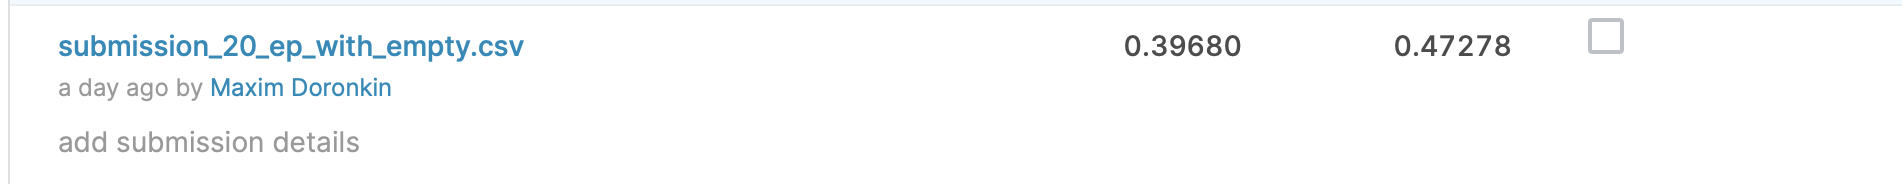

In [ ]:
model_densenet.load_state_dict(torch.load('densenet_epoch_last'))

## Формирование предсказания

При формировании предсказания много смотрел на тестовые данные и игрался с threshold. Была идея ставить иной threshold, названный мною EMPTY_STRING_THRESHOLD, на те картинки, где сеть совсем ничего не обнаружила, так как казалось, что в тесте почти на каждой картинке есть хотя бы одна банковская карта, но эта идея в итоге не зашла и только портила скор на LB, так что тут уже её убираю.

In [ ]:
def get_prediction(dataset,  model):

    """
    Функция для формирования результата. 
    """
    
    model.eval()
    cpu_device = torch.device("cpu")

    def c_sort(sub_li):

        sub_li.sort(key = lambda x: (x[0], x[1]))
        return sub_li
    
    def get_reversed_class(number):

        cards = {
            1:'VI',
            2:'MA',
            3:'EX', 
            4:'PC', 
            5:'ST',
            6:'UY'
                }
        return cards[number]


    preds = []
    scores = []
     #предсказание
    for images in metric_logger.log_every(dataset, 100, header):

        images = torch.stack([images[0][0].to(device), images[1][0].to(device), images[2][0].to(device) ], dim=0).unsqueeze(0)

        torch.cuda.synchronize()
        model_time = time.time()
        with torch.no_grad():
            outputs = model(images)

            outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        preds.append(outputs)
        
        labels_pred = []
        names_pred = []
        
    imgs_name = test_df.image.unique().tolist()

    # извлечение предсказаний, сортировка и оздание датафрейма
    for ind, i in enumerate(preds):
        
        _temp_boxes = i[0]['boxes'].cpu().detach().numpy().tolist()
        _temp_label = i[0]['labels'].cpu().detach().numpy().tolist()
        _temp_confidence = i[0]['scores'].cpu().detach().numpy().tolist()

        for index, _ in enumerate(_temp_boxes):
            _temp_boxes[index].append(get_reversed_class(_temp_label[index]))
            _temp_boxes[index].append(_temp_confidence[index])
            

        _temp_boxes = c_sort(_temp_boxes)
        names_pred.append(imgs_name[ind])
        scores.append([" ".join(str([j[4] for j in _temp_boxes])),[j[5] for j in _temp_boxes]])
        labels_pred.append( " ".join([j[4] for j in _temp_boxes if j[5] > THRESHOLD]))
             
    d = {'image': names_pred, 'payment': labels_pred}
    
    t = {'payment-score': scores}
    df = pd.DataFrame(data=d)
    t_df = pd.DataFrame(data=t)
        
    return df , t_df

In [ ]:
metric_logger = utils.MetricLogger(delimiter="  ")

header = "Test:"


dataloader_test = DataLoader(
    test_data, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)

model_densenet.cuda()

g_predictions = get_prediction(dataloader_test, model_densenet)
predictions = g_predictions[0]
scores = g_predictions[1]

In [ ]:
predictions.to_csv("submission_07.csv", index=None)